# Fitting Emission Lines

The key to working with spectra is being able to measure the line flux of an emission line. This is done by fitting a Gaussian model to the emission line. This process can be a bit more complicated if the lines are blended, meaning that what looks to be one line in the spectra is actually made up of a variety of other emission lines. In the next section we go over how to fit an emission line and slowly increase the complexity of the model and fitting routines.

# Using Curve Fit

Curve fit is a very powerful tool to fit any model to any kind of data. The power of curve_fit comes from the ability to have a custom model that the user can create. The one condition for this function that the user defines is just that it has to be in the format that curve_fit expects it in. The format for this function is f(x, param1, param2, ...) where x is the first argument in the function and then the rest are the parameters you are trying to fit in any order you like. 

For the purpose of fitting an emission line we will be fitting a Gaussian to this and so our model will have the form:

$G(x) = Ae^{\frac{(x - \mu)^2}{2\sigma^2}}$

Here A represents the amplitude of the Gaussian and controls the height of the Gaussian. $\mu$ controls where the Gaussian is centered and this should correspond to the wavelength of the emission line. $\sigma$ controls how wide the emission line is, a larger value of $\sigma$ means a broader line. x in this example corresponds to your wavelength array. 

Note that the units of A, $\mu$ and $\sigma$ are solely determined by the data you provide curve_fit. So if the spectra is in units of Jy then the Amplitude will have units of Jy, if the wavelength inputted is in microns then $\mu$ and $\sigma$ will be in microns. 

The function curve_fit takes in some parameters and then you can customize it further with other key-word arguments. The basic input to get curve_fit to start fitting is it needs the model that you are trying to fit in the format specified above, the x and y data, and an intitial guess to start the process to finding the best fit parameters.

    Inputs:
    Model Function
    x-data
    y-data
    Initial Guesses

The output of curve fit will be two things, the first thing you will get back is the best fit parameter values and the second is a covariance matrix that holds the uncertainties and correlations of each of the parameters. The thing we are really after is the best fit parameters so we will not cover the covariance matrix in too much detail as we will be using more sophisticated ways of getting the error on our parameters in the upcoming notebooks.

    Outputs:
    Best Fit Parameters
    Covariance Matrix

The best fit parameters will be stored in one variable as a list and they will be in the same order as your user-defined model, so to access a certain parameter you will need to use python indexing for that. 

Let us code this model up in Python and use it to fit an emission line.

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
#defining the model for the emission line as a Gaussian
def continuum(x, m, b, line_center):
    return m*(x - line_center) + b

def gaussian(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/(2*sigma**2))

def line_model(x, A, mu, sigma, m, b):
    
    '''
    This is the model for the emission line. Only to be used on a continuum subtracted spectrum.
    
    Gauss = Ae^(-(x-mu)^2/2 sigma^2)
    
    '''
    
    return gaussian(x, A, mu, sigma) + continuum(x, m, b, mu)

    

# Zooming in on the emission line

If you provide curve fit with the entire x and y data of the spectrum it will use all that info in the estimation of the parameters. This is a bit much for our purposes as we are only focused on one line so we will only provide curve fit with the data around the emission line. 

Let us do this by looking around a window near the emission line and using only this data into curve_fit.

Let us look at Halpha to start with, since you know the redshift for this source you can figure out where it is in the observed frame using H$\alpha_{obs}$ = H$\alpha_{rest}$ (1+z)

Come up with a good window to zoom into H$\alpha$, you can use plt.xlim here to zoom in to find the bounds.

In [10]:
##
#Your code Here
##
tab = Table.read('spec-1678-53433-0425.fits')
wave, flux = 10**tab['loglam'], tab['flux']

In [ ]:
plt.step(wave, flux, where = 'mid')
plt.xlim(6500, 7000)
#plt.ylim(0, 250)

In [ ]:
plt.step(wave, flux, where = 'mid')
plt.xlim(6820, 6840)

Once you have a good bounds for the line you can make a boolean mask to subselect the data only within this range

In [4]:
mask = (wave > 6820) & ((wave < 6840))

curve_fit_xdata = wave[mask]
curve_fit_ydata = flux[mask]

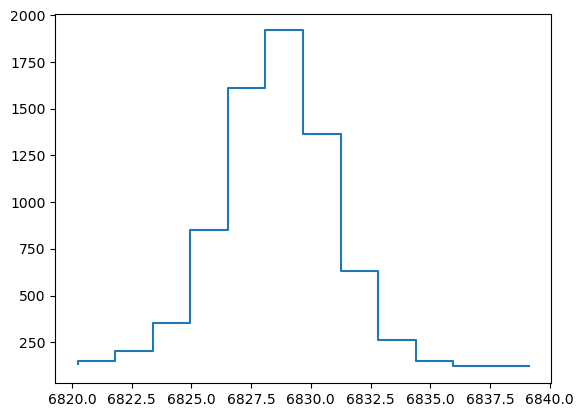

In [5]:
plt.step(curve_fit_xdata, curve_fit_ydata)

# Initial Guesses

For curve fit to work you need to provide the function with a good initial guess. Try to come up with good guesses for A, $\mu$, $\sigma$, m and b.

Recall here that A is the amplitude of the emission line,  $\mu$ is the line center, $\sigma$ is the width of the gaussian, m and b are the slope and y-intercept respectrively

In [ ]:
p0 = [2000, 6830, 5, 0, 220]

popt, cov = curve_fit( line_model, #function to fit
                      curve_fit_xdata, #xdata
                      curve_fit_ydata, #ydata
                      p0 = p0)

In [ ]:
popt

In [ ]:
xdata = np.linspace(6820, 6840, 1000)

line = continuum(xdata, popt[-2], popt[-1], popt[1])
gauss = gaussian(xdata, *popt[:3])
                 
plt.step(wave, flux, where = 'mid', label = 'data')
#plt.plot(xdata, line_model(xdata, *popt), label = 'Full Model')#, ls = '--')
plt.plot(xdata, line, label = 'Continuum')
plt.plot(xdata, gauss+line, label = 'Gauss', ls = '--')
plt.legend()
plt.xlim(6820, 6840)

# Calculating Flux

When we are fitting a Gaussian to an emission line our end goal is to compute the flux of that emission line. When we use a Gaussian as our fitting function we can exploit the fact that the integral of a Gaussian from $-\inf$ to $+\inf$ has a nice functional form: $A\sigma\sqrt{2\pi}$. Here A is the amplitude of the Gaussian, $\sigma$ is the standard deviation of the Gaussian. 

# Note on Units:

Flux has units of energy/s/Area, when we work with spectra they are either in $F_{\nu}$ or $F_{\lambda}$ or some units that relates to these two like the Jansky. When you are trying to compute fluxes you need to ensure that the units of your amplitude and the $\sigma$ work in such a way that you get back the units of flux which in general terms are energy/s/Area. 

Let look at an example where Amplitude is in $F_{\nu}$ in Jy and the sigma is in microns. Similar to some JWST spectra you may be working with. We need to first convert Jy to $erg/s/cm^2/Hz$ and if we have sigma in microns we have the following:

$F[units] = \frac{erg}{s cm^2 Hz} * \mu m$


The above units **DO NOT** give back the units of flux we need as the Hz and $\mu$ m do not cancel out. Thus, you need to make sure that you convert the flux to $F_{\lambda}$ which has units of erg/s/cm^2/Angstroms and then convert your wavelength to Angstroms. If you do this then you get the following:

$F[units] = \frac{erg}{s cm^2 \AA} * \AA =  \frac{erg}{s cm^2}$

The Angstroms cancels out between the two and then you are left with something in units of energy/s/Area which is erg/s/$cm^2$. 

Let us see how we can get flux from this spectra after performing the fitting by analyzing the best fit parameters and their units. 

In [ ]:
A = popt[0]
sigma = popt[2]
flux = A * sigma * np.sqrt(2*np.pi)

# Part 3: Taking Line Ratios

Emission line ratios serve as powerful diagnostics for determining the physical conditions within galaxies. By comparing the relative strengths of specific spectral lines—such as [O III]/Hβ or [N II]/Hα—astronomers can infer key properties including gas-phase metallicity, ionization parameter, electron density, and the presence of active galactic nuclei (AGN). These ratios are sensitive to the physical state of the interstellar medium and can distinguish between star-forming regions and AGN-dominated environments. Diagnostic tools like the BPT diagram and photoionization models (e.g., CLOUDY) help translate these observed ratios into physical insights, enabling studies of galaxy evolution across cosmic time.


Some useful line ratios:

Metallicity:
R23 = ([O II] λ3727 + [O III] λ4959,5007) / Hβ

Ionization Parameter:
[O III] λ5007 / [O II] λ3727

Density: 
[O II] λ3726 / λ3729
[S II] λ6717 / λ6731

BPT Diagram:
[O III] λ5007 / Hβ vs. [N II] λ6584 / Hα 

3878.5398199999995


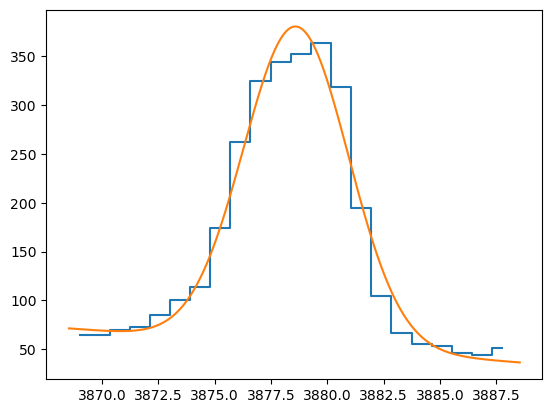

5058.64826


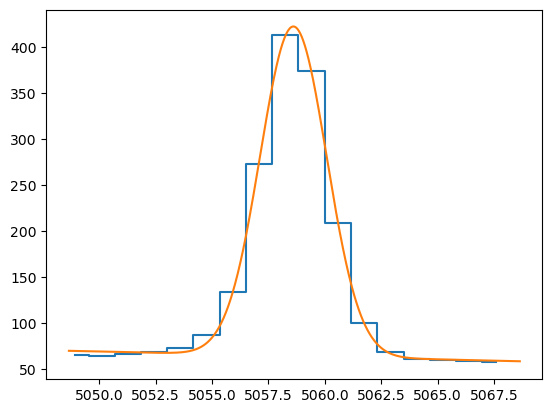

5209.54396


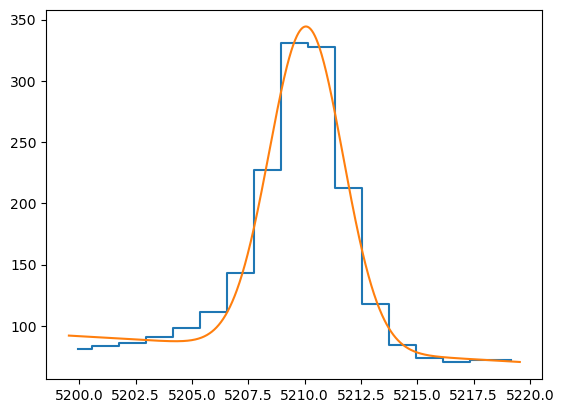

6829.85158


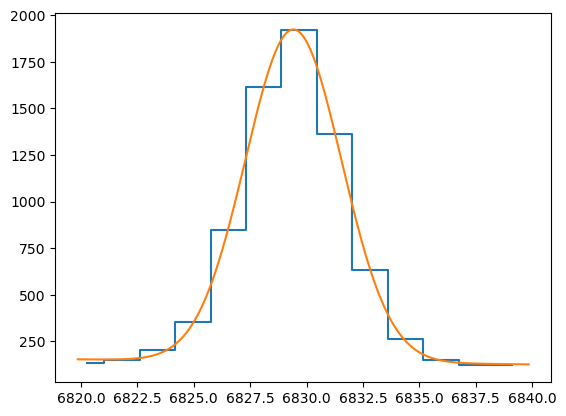

6850.664779999999


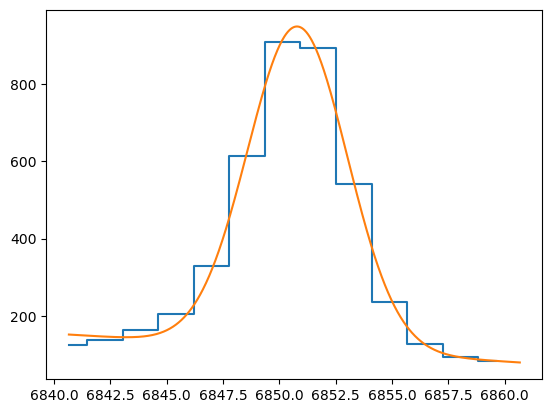

In [29]:
#                                  OII3727,  Hbeta, OIII5007, Halpha, NII_6584
rest_frame_wavelengths = np.array([    3727   ,  4861     ,     5006   ,      6563    ,     6583   ])

z = 0.04066

#convert to observed frame
obs_wavelengths = rest_frame_wavelengths*(1+z)

#compute fluxes per line

fluxes = []

for lam in obs_wavelengths:

    print(lam)
    #mask the data
    mask = (wave > lam - 10) & (wave < lam + 10) #making a mask to grab the emission line

    fit_wave, fit_flux = wave[mask], flux[mask]

    guess_A = np.amax(fit_flux) 
    guess_mu = lam
    guess_sigma = 20
    guess_m = 0
    guess_b = fit_flux[0] #or fit_flux[-1]
    
    # #fit the model
    p0 = [guess_A, guess_mu, guess_sigma, guess_m, guess_b]
    
    popt, cov = curve_fit(line_model, #function to fit
                           fit_wave, #xdata
                           fit_flux, #ydata
                           p0 = p0, 
                           bounds = [[guess_A/3, 0, 0, -np.inf, 0], #this is lower bounds on parameters
                                     [guess_A*2, np.inf, np.inf, np.inf, np.inf] #this is upper bounds on parameters
                                    ])

    plt.figure()
    plt.step(fit_wave, fit_flux, where= 'mid') #plots my input data
    xarr = np.linspace(lam-10, lam+10, 1000)  #generates a finer x grid for my model
    plt.plot(xarr, line_model(xarr, *popt))   #Here I generate the model based off of the best fit parameters
    plt.show()
    
    # #compute the flux
    A = popt[0]
    sigma = popt[2]
    flux_computed = A * sigma * np.sqrt(2*np.pi)
    
    fluxes.append(flux_computed)

In [14]:
fluxes

[1905.947612927199,
 1322.6150395737511,
 1081.4217491807694,
 6271.513875472874,
 4626.0032786475185]

In [21]:
nii_ha = fluxes[-1] / fluxes[-2]
oiii_hb = fluxes[2] / fluxes[1]
oiii_oii = fluxes[2] / fluxes[0]

# Print results
print(f"[NII]/Halpha = {nii_ha:.2f}")
print(f"[OIII]/Hbeta = {oiii_hb:.2f}")
print(f"[OIII]/[OII] = {oiii_oii:.2f}")

[NII]/Halpha = 0.49
[OIII]/Hbeta = 0.82
[OIII]/[OII] = 0.57


In [22]:
log_oiii_hb = np.log10(oiii_hb)
log_nii_ha = np.log10( nii_ha)

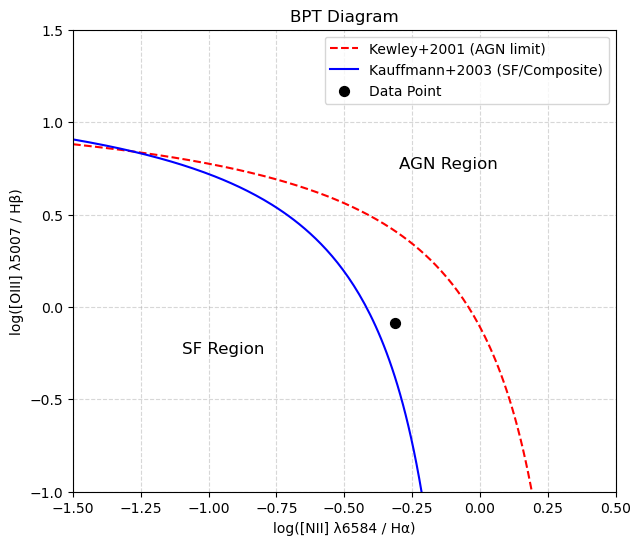

In [23]:
# Generate x values for the demarcation lines
x = np.linspace(-1.5, 0.5, 200)

mask_kauffman = x > -0.1
mask_kewely = x > 0.25

# Kewley 2001 (maximum starburst line)
kewley_y = 0.61 / (x - 0.47) + 1.19
kewley_y[mask_kewely] = np.nan  # Mask out the region where Kewley line is not valid

# Kauffmann 2003 (empirical SF-AGN divider)
kauffmann_y = 0.61 / (x - 0.05) + 1.3
kauffmann_y[mask_kauffman] = np.nan  # Mask out the region where Kauffmann line is not valid

# Plot
plt.figure(figsize=(7, 6))
plt.plot(x, kewley_y, 'r--', label='Kewley+2001 (AGN limit)')
plt.plot(x, kauffmann_y, 'b-', label='Kauffmann+2003 (SF/Composite)')

plt.scatter(log_nii_ha, log_oiii_hb, c='black', s=50, edgecolor='k', label='Data Point')


plt.xlabel('log([NII] λ6584 / Hα)')
plt.ylabel('log([OIII] λ5007 / Hβ)')
plt.xlim(-1.5, 0.5)
plt.ylim(-1.0, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.title('BPT Diagram')
plt.annotate('SF Region', xy=(0.2, 0.3), xycoords='axes fraction', fontsize=12,)
plt.annotate('AGN Region', xy=(0.6, 0.7), xycoords='axes fraction', fontsize=12,)
plt.show()


# Extra Problem

Hα is one of the most widely used tracers of star formation rate (SFR) in galaxies! Here's a quick breakdown of how students can measure SFR from Hα, followed by a scaffolded Jupyter notebook they can work through.

Why Hα Traces Star Formation

Hα is produced in H II regions around young, massive stars (O and B types).

These stars have lifetimes of only ~10 Myr, so Hα traces very recent star formation.

The Hα luminosity is directly proportional to the ionizing photon rate, which is tied to the SFR.

The widely used calibration from Kennicutt (1998) for a Salpeter IMF is:

$SFR (M_{\odot}/yr) =7.9 \times 10^{-42}×𝐿(H\alpha)  [M_{\odot}/yr]$

To compute luminosity you need to know the distance to the source and use the formula

$L = f4\pi D_L^2$

Where $D_L$ is the luminsoity distance and you can get that from the astropy.cosmology package

In [24]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [25]:
#to compute a luminosity distance you need the redshift of the source
# try computing the luminosity distance for a redshift of 1, 2, 3, 4
cosmo.luminosity_distance(z)

<Quantity 185.69149477 Mpc>

In [27]:
#compute the SFR of this source using the luminosity of Halpha 

flux_halpha = fluxes[-2]*1e-17

D_L = cosmo.luminosity_distance(z).to(u.cm)
L = flux_halpha * 4 * np.pi * D_L**2


sfr = 7.9e-42 * L
print(sfr)

3.1067219858456547 cm2
